# Importing packages

In [38]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [ ]:
import sys
# sys.path.append('/Users/c.kieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [40]:
import pickle

In [41]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [ ]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "Mistic2_EchoAdj" #what data did you put in
fileName_common = "_time-comp_linear" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_241118_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "Mistic2_EchoAdj_time_linear_", folderName_common= "241118", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [ ]:
#parameters of SVM 
red_factor = 0.05

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

C_range = [2**x for x in range(-2,5)]
# gamma_range = [2**x for x in range(-9,1)]


kernel_type = "rbf"

rank_weights = [0,0.25,0.50,0.75,1]

# importing our data

In [44]:
dataFileName = "AL-KnownPts_EchoAdj_exG01J01-time-comp_1Sheet_20241024_v1.xlsx"

In [45]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

# Setting up classifier

## Scaling data and defining test set

In [46]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]


#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

In [47]:
X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

## define cross validation

In [48]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [ ]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-12)


parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

# feature selection

In [ ]:

svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 55, Score: 0.678
Number of Features: 52, Score: 0.667
Number of Features: 49, Score: 0.689
Number of Features: 46, Score: 0.711
Number of Features: 43, Score: 0.719
Number of Features: 40, Score: 0.644
Number of Features: 37, Score: 0.667
Number of Features: 35, Score: 0.633
Number of Features: 33, Score: 0.633
Number of Features: 31, Score: 0.633
Number of Features: 29, Score: 0.667
Number of Features: 27, Score: 0.678
Number of Features: 25, Score: 0.678
Number of Features: 23, Score: 0.694
Number of Features: 21, Score: 0.717
Number of Features: 19, Score: 0.736
Number of Features: 18, Score: 0.747
Number of Features: 17, Score: 0.736
Number of Features: 16, Score: 0.761
Number of Features: 15, Score: 0.740
Number of Features: 14, Score: 0.740
Number of Features: 13, Score: 0.753
Number of Features: 12, Score: 0.744
Number of Features: 11, Score: 0.737
Number of Features: 10, Score: 0.774
Number of Features: 9, Score: 0.782
Number of Features: 8

In [51]:
# add pickling stage here so that you can use this data for easy replotting

#if not already pickled use this block
pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
pickle_file = open(pickle_filePath, 'wb')
pickle.dump(svm_set_ranks, pickle_file)



# Performance plots

## F1 and AUC plots

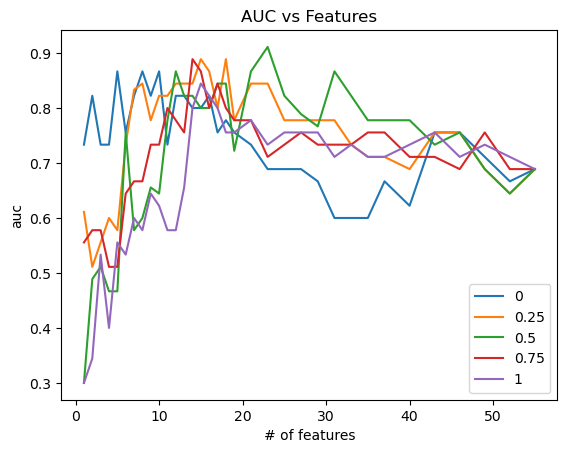

In [52]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

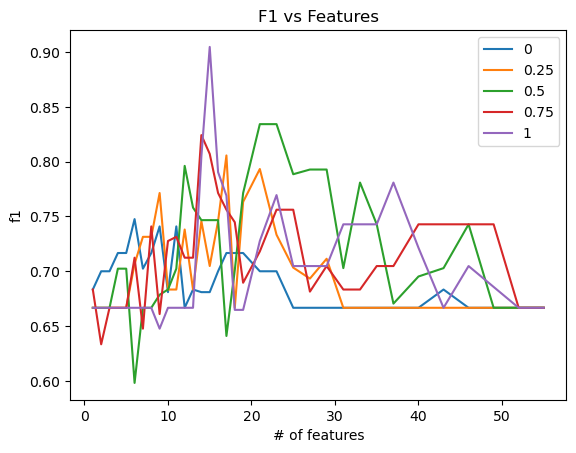

In [53]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

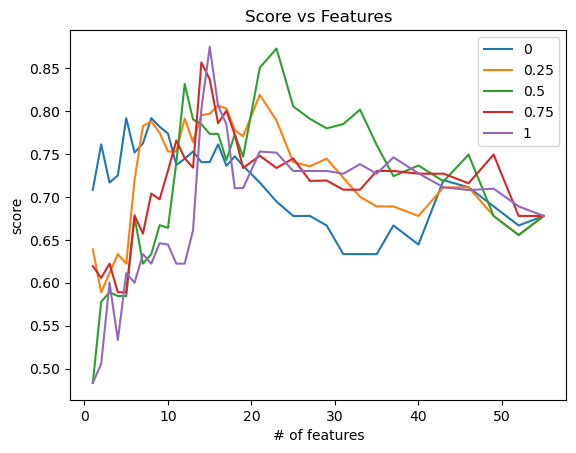

In [54]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [55]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score())

# selected_run = 4 
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.6893665223665224,
 0.7082417027417026,
 0.7181688311688311,
 0.7060613275613276,
 0.6886565656565656]

In [56]:
# svm_set_ranks[selected_run].performance_.keys()

In [66]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [67]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [57]:
for i in range(len(rank_weights)): 
    # print("test")
    print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
    print("features: ", "\n", list(X.columns[svm_set_ranks[i].features]), "\n")

weight  0  : {'f1': 0.7166666666666666, 'auc': 0.8666666666666666, 'score': 0.7916666666666666, 'C': 2, 'gamma': 0.0078125, 'num_features': 5, 'mean_nSV': 29.0} 

features:  
 ['Beta-2-Microglobulin Result', 'Hemoglobin Result', 'MCHC Result', 'MCV Result', 'Pct. Mono Result'] 

weight  0.25  : {'f1': 0.7933333333333333, 'auc': 0.8444444444444444, 'score': 0.8188888888888888, 'C': 8, 'gamma': 0.015625, 'num_features': 21, 'mean_nSV': 24.8} 

features:  
 ['HemeTx', 'HemeTx Number', 'Albumin Electrophoresis Result', 'Beta-2-Microglobulin Result', 'Creatinine Result(mg/dL)', 'HCT Result', 'Hemoglobin Result', 'Kappa Free Light Chains Result (mg/L)', 'LDH Result(U/L)', 'MCH Result(pg)', 'MCHC Result', 'MCV Result', 'Nucleated RBC Result', 'Pct. Mono Result', 'RBC Result', 'Serum Electrophoresis Alpha 1 Result', 'Serum Electrophoresis Alpha 2 Result', 'Serum Electrophoresis Beta Result', 'Serum Electrophoresis Gamma Result', 'WBC Result(k/uL)', 'NT Pro BNP (B-Type Natriuretic Peptide)'] 



In [58]:
# X.columns[svm_set_ranks[3].features]

In [59]:
# #saving the feature ranking, performance, and model evaluations to spreadsheets
# bestModel = svm_set_ranks[selected_run]

# #collecting the performance as a dataframe
# df_bestPerformance = pd.DataFrame(svm_set_ranks[selected_run].performance_)
# outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(selected_run) + "_best model performance")


# df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[selected_run].features]))
# #saving the best features
# outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(selected_run) + "_features")



In [ ]:
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    print("\n The model is: ")
    print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
    print("True Negative: ", tn)
    print("false positive: ", fp)
    print("false negative: ", fn)
    print("true positive: ", tp)
    print("true positive rate or recall/sensitivity: ", recall)
    print("positive predictive value or precision: ", precision)
    print("specificity or true negative rate: ", specificity)
    print("auc: ", auc)
    print("f1 score: ", f1)

# plots for best model

## pair plots

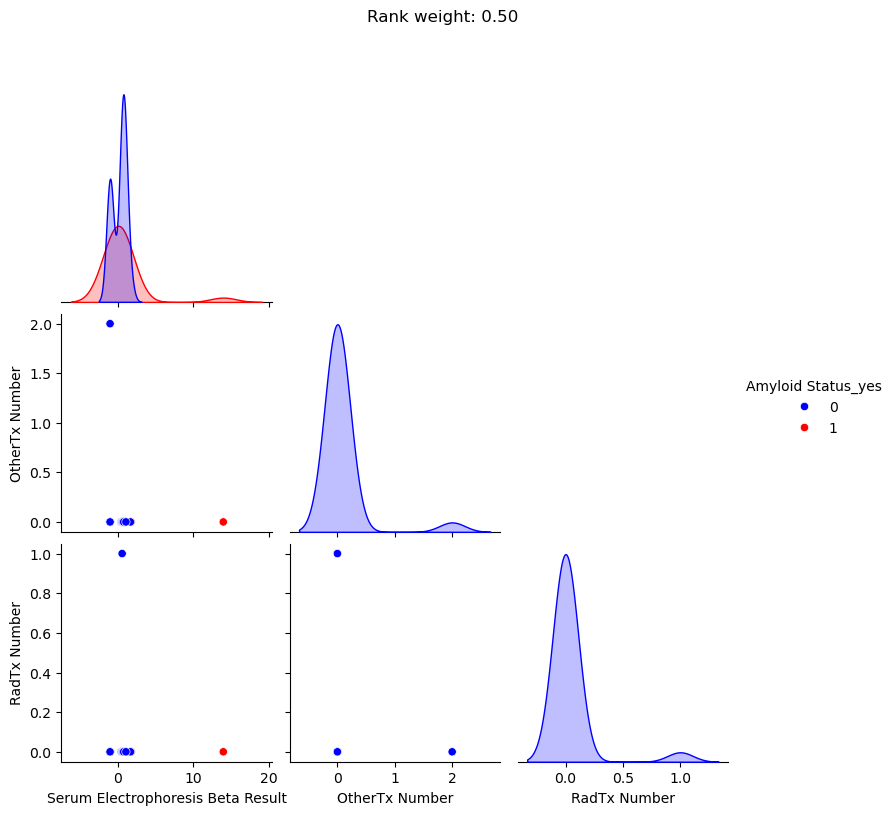

In [68]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[0:3]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

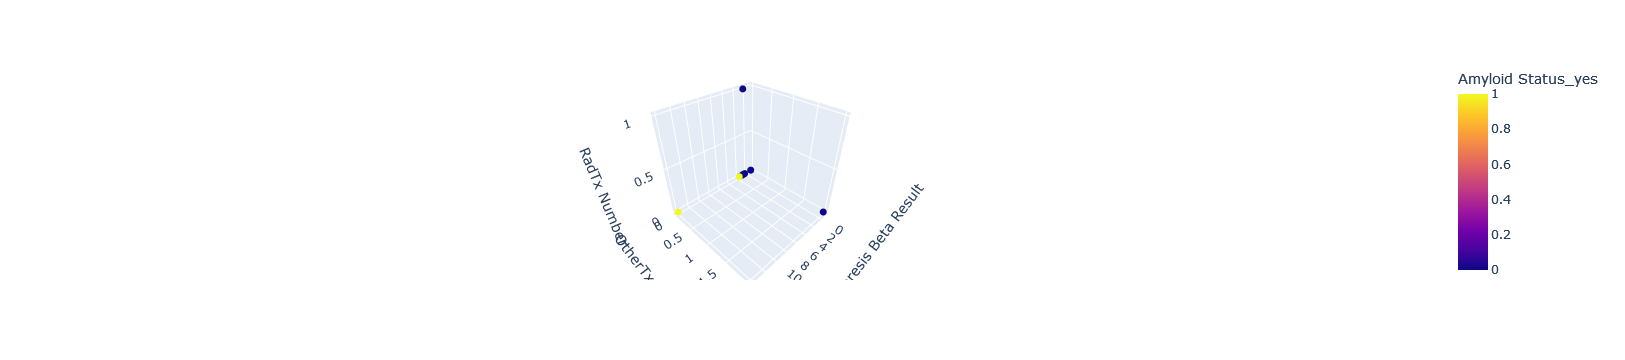

In [61]:
fig = px.scatter_3d(dataTable, x=top_features[0], y=top_features[1], z=top_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



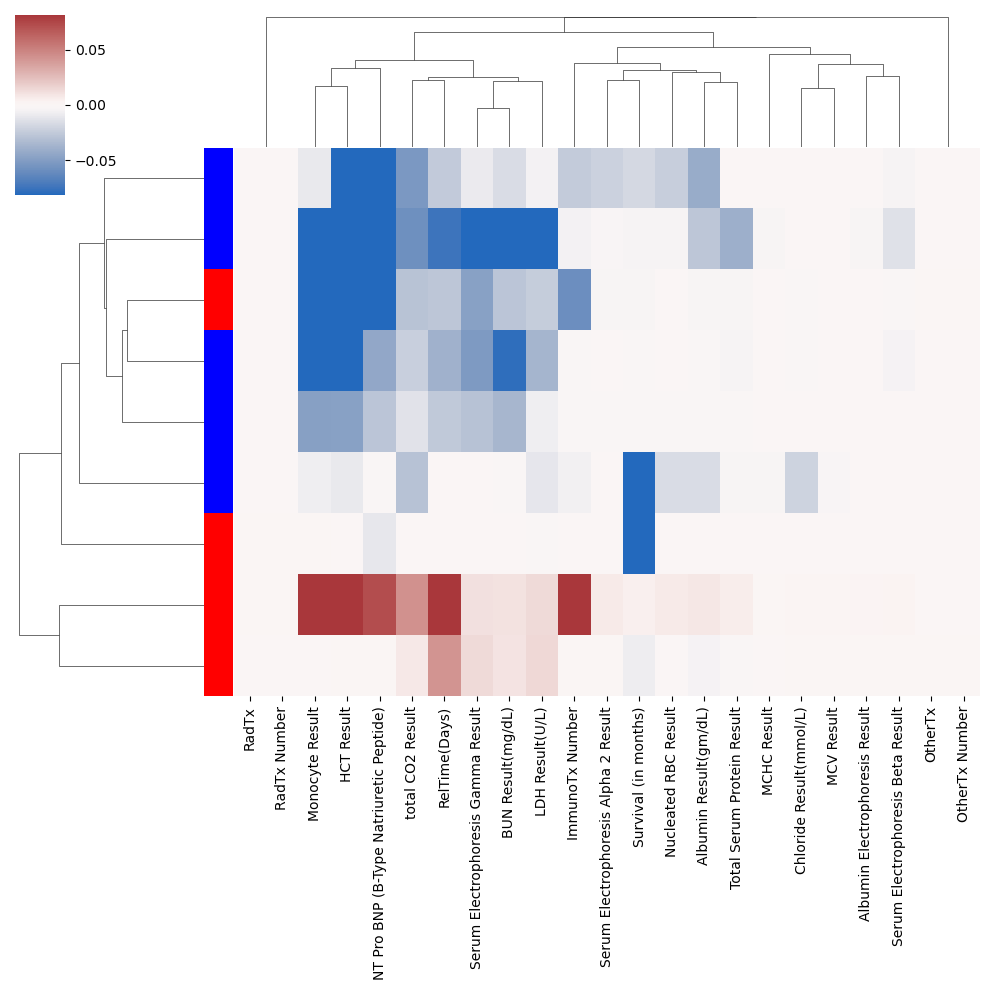

In [65]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_test)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_IGheatmap"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_all)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_Xall_IGheatmap"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

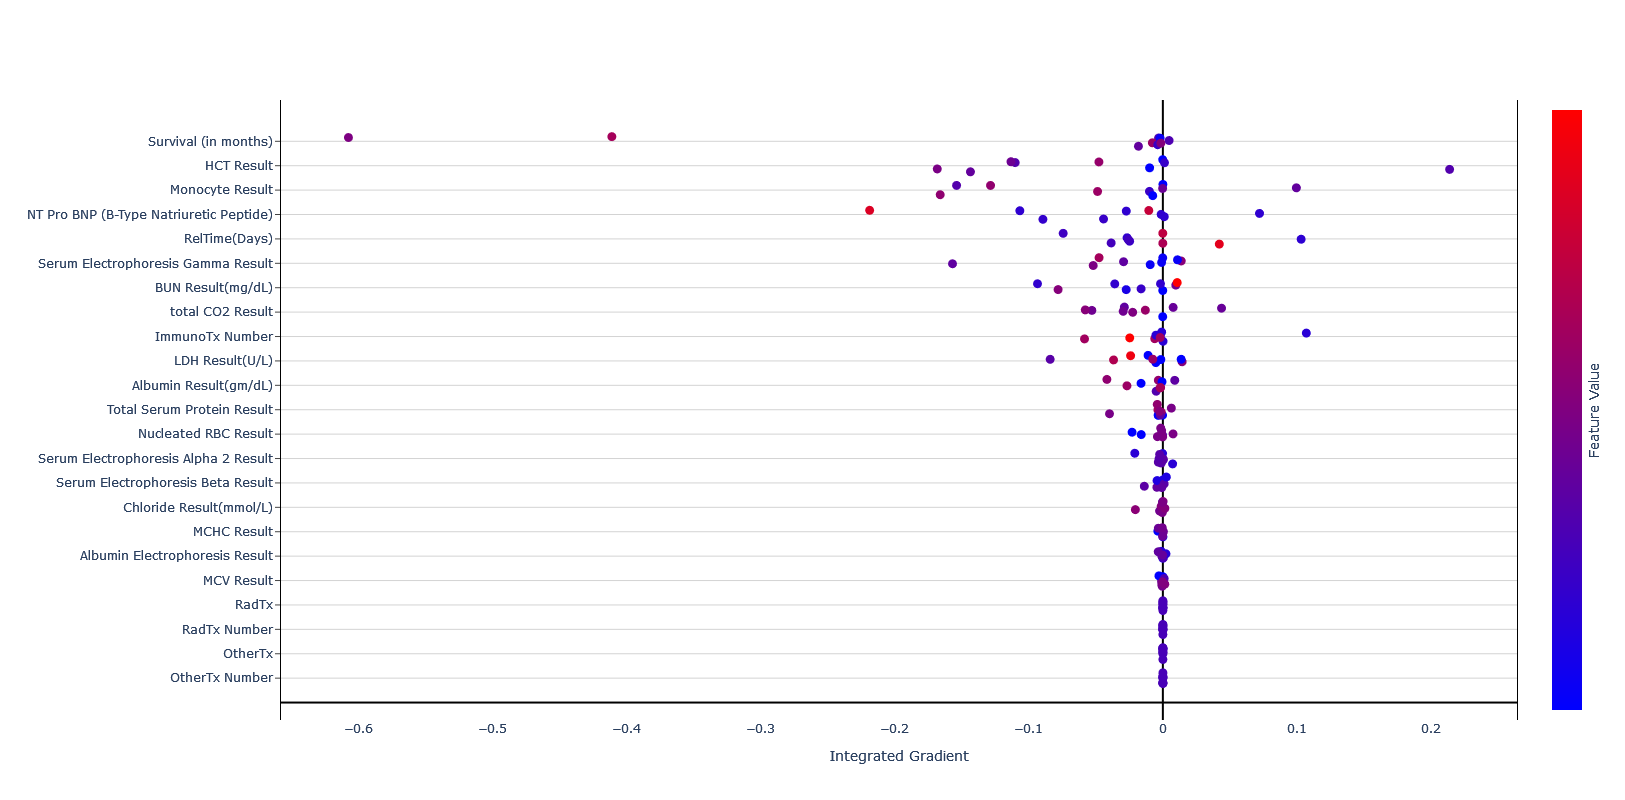

In [63]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_test = pd.DataFrame(X_test[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_test.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

# #saving figure
# figCommon = fileName_common + str(selected_run) + "_attribution"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_all = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_all.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_Xall_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
#fig.show()

## 2x2

In [ ]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_test[feat_1], y = IGtable[feat_1], color = df_X_test[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

KeyError: 'Texture worst'

In [ ]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_all[feat_1], y = IGtable[feat_1], color = df_X_all[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_Xall_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()